# 와잘알을 위한 와인 추천 (회귀 기반)

-사용자가 와인의 속성(당도, 산도, 바디, 타닌, 강도, 탄산)에 대해 선택 시, 와인 속성의 유사도가 높은 와인을 추천

dataset : vivino

| 컬럼 명                    | 의미         |
|:------------------------|:-----------|
| vintage_id              | 빈티지 아이디 번호 |
| vintage_name            | 빈티지 이름     |
| vintage_year            | 빈티지 생산년도   |
| vintage_price           | 빈티지 가격     |
| vintage_ratings_average | 빈티지 평균 평점  |
| vintage_ratings_count   | 빈티지 평점 개수  |
| vintage_wine_id         | 와인 아이디 번호  |
| vintage_wine_name       | 와인 이름      |
| vintage_winery          | 와이너리       |
| vintage_country         | 생산 국가      |
| vintage_region          | 생산 지역      |
| vintage_wine_type_id    | 와인 종류      |
| acidity                 | 산도         |
| fizziness               | 탄산         |
| intensity               | 강도         |
| sweetness               | 당도         |
| tannin                  | 타닌         |
| flavor                  | 맛          |
| foods                   | 음식         | 


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
wine_info_df = pd.read_csv('./data/vivino_data_241107.csv')
wine_info_df.head() # vintage_wine_type_id 7 dessert, # 1 red, 2 white, 3 sparkling, 4 rose, 24 fortified


,vintage_id,vintage_name,vintage_year,vintage_price,vintage_ratings_average,vintage_ratings_count,vintage_wine_id,vintage_wine_name,vintage_winery,vintage_country,vintage_region,vintage_wine_type_id,acidity,fizziness,intensity,sweetness,tannin,flavor,foods
0,177404982,Carl Loewen 1896 Riesling 2023,2023,82045,5.0,115,1945087,1896 Riesling 2023,Carl Loewen,Germany,Mosel,2,4.61,NaN,3.32,2.05,NaN,tree_fruit,"['Pork', 'Shellfish', 'Spicy food', 'Poultry',..."
1,1510217,Château Haut-Brion Pessac-Léognan (Premier Gra...,1989,3244496,4.8,1538,1152755,Pessac-Léognan (Premier Grand Cru Classé) 1989,Château Haut-Brion,France,Pessac-Léognan,1,4.22,NaN,4.08,1.67,4.23,oak,"['Beef', 'Lamb', 'Game (deer, venison)', 'Poul..."
2,2611979,Château Latour Grand Vin Pauillac (Premier Gra...,1982,2759686,4.8,1445,1655970,Grand Vin Pauillac (Premier Grand Cru Classé) ...,Château Latour,France,Pauillac,1,4.12,NaN,4.12,1.68,4.13,oak,"['Beef', 'Lamb', 'Game (deer, venison)', 'Poul..."
3,170413977,Domaines Ott Clos Mireille Rosé (Coeur de Grai...,2022,59594,4.8,581,1382222,Clos Mireille Rosé (Coeur de Grain) 2022,Domaines Ott,France,Côtes de Provence,4,3.77,NaN,2.50,1.33,NaN,citrus_fruit,"['Pork', 'Shellfish', 'Vegetarian', 'Poultry']"
4,1688597,Krug Clos du Mesnil 2000,2000,2175423,4.8,347,79635,Clos du Mesnil 2000,Krug,France,Champagne,3,4.54,4.22,3.97,NaN,NaN,non_oak,"['Pork', 'Rich fish (salmon, tuna etc)', 'Shel..."


In [29]:
# 와인 타입 숫자에서 문자열로 변경
vintage_wine_type_id_dic = {
    1 : 'Red',
    2 : 'White',
    3 : 'Sparkling',
    4 : 'Rose',
    7 : 'Dessert',
    24 : 'Fortified',
    25 : 'Unknown'
}

wine_info_df['vintage_wine_type_id'] = wine_info_df['vintage_wine_type_id'].apply(lambda x: vintage_wine_type_id_dic[x])

# 컬럼명 'vintage_wine_type_id'에서 'vintage_wine_type' 으로 변경
wine_info_df = wine_info_df.rename(columns={'vintage_wine_type_id': 'vintage_wine_type'})

In [30]:
print(wine_info_df.shape)
wine_info_df.info()

(3675, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3675 entries, 0 to 3674
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   vintage_id               3675 non-null   int64  
 1   vintage_name             3675 non-null   object 
 2   vintage_year             3675 non-null   object 
 3   vintage_price            3675 non-null   int64  
 4   vintage_ratings_average  3675 non-null   float64
 5   vintage_ratings_count    3675 non-null   int64  
 6   vintage_wine_id          3675 non-null   int64  
 7   vintage_wine_name        3675 non-null   object 
 8   vintage_winery           3674 non-null   object 
 9   vintage_country          3675 non-null   object 
 10  vintage_region           3675 non-null   object 
 11  vintage_wine_type        3675 non-null   object 
 12  acidity                  3555 non-null   float64
 13  fizziness                507 non-null    float64
 14  intensity    

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 속성, 타겟 설정
features = ['acidity', 'fizziness', 'intensity', 'sweetness', 'tannin']
target = 'vintage_ratings_average'

# Drop rows with missing target values
wine_info_df = wine_info_df.dropna(subset=[target])

# Fill missing values in features with the median of each column
wine_info_df[features] = wine_info_df[features].fillna(wine_info_df[features].median())

# Split data into training and testing sets
X = wine_info_df[features]
y = wine_info_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2940, 5), (735, 5), (2940,), (735,))

In [46]:

# Initialize and train the XGBoost regressor
xgb_model = XGBRegressor(n_estimators=5000, max_depth=5, learning_rate=0.5, random_state=0)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse_xgb}")


Mean Squared Error: 0.015724514264281196


In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load the data
data = pd.read_csv('./data/vivino_data_241107.csv')

# Define the features and target variable
features = ['acidity', 'fizziness', 'intensity', 'sweetness', 'tannin']
target = 'vintage_ratings_average'

# Drop rows with missing target values
data = data.dropna(subset=[target])

# Fill missing values in features with the median of each column
data[features] = data[features].fillna(data[features].median())

# Split data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the XGBoost regressor
xgb_model = XGBRegressor(random_state=0)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse_xgb}")

# Example recommendation based on custom input
def recommend_wine(acidity, fizziness, intensity, sweetness, tannin):
    sample = pd.DataFrame([[acidity, fizziness, intensity, sweetness, tannin]], columns=features)
    predicted_rating = xgb_model.predict(sample)[0]
    return predicted_rating

# Example usage of the recommendation function
predicted_rating = recommend_wine(acidity=4.0, fizziness=3.5, intensity=4.5, sweetness=2.0, tannin=3.5)
print(f"Predicted wine rating: {predicted_rating}")

Mean Squared Error: 0.013699267646433073
Predicted wine rating: 4.551413536071777


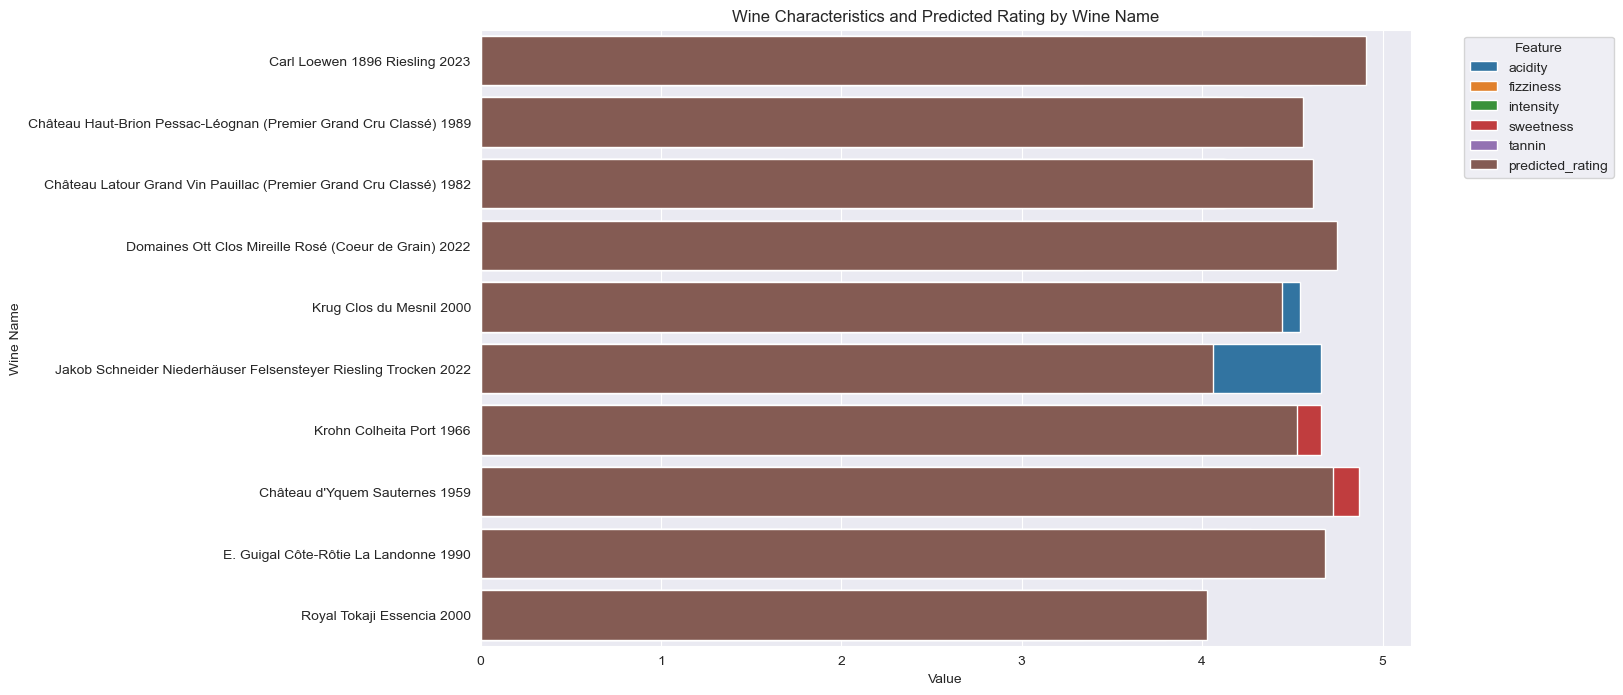

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use a subset of the data for visualization (e.g., first 10 wines) to keep the plot readable
data_visual = data.head(10).copy()  # Adjust to any number of wines you want to visualize

# Predict ratings for these wines
data_visual['predicted_rating'] = xgb_model.predict(data_visual[features])

# Select relevant columns (wine name, features, and predicted rating) for visualization
visualization_df = data_visual[['vintage_name'] + features + ['predicted_rating']]

# Melt the DataFrame for easier plotting
visualization_df_melted = pd.melt(visualization_df, id_vars='vintage_name', 
                                  var_name='Feature', value_name='Value')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Value', y='vintage_name', hue='Feature', data=visualization_df_melted, dodge=False)
plt.title("Wine Characteristics and Predicted Rating by Wine Name")
plt.xlabel("Value")
plt.ylabel("Wine Name")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
